# Model hiper optimization

In [1]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [2]:
# configs.
%matplotlib inline

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1.a - df_test 04-19to05-19.feather', '1.1 - df_test 04-19to04-19.feather', '1.1.a - df_train  without nulls.feather', '1.1.a - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.1.b - 01-17 to 01-19 - df_val 01-19to03-19.feather', '1.1.a - df_test 04-19to04-19.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.1 - df_train only 2018 without nulls.feather', '1.1 - df_train with nan.feather', '1.1.a - df_train only 2018 without nulls.feather', '1.1.a - df_train with nan.feather']


## Loading training and validation datasets

In [3]:
df = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather"))
df_val = pd.read_feather(os.path.join(path, "1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
df_val["FECHA_SINI"].min(), df_val["FECHA_SINI"].max()

(Timestamp('2019-02-01 00:00:00'), Timestamp('2019-03-31 00:00:00'))

In [5]:
# dropping index variables
# to_drop = ["index"]
# df.drop(to_drop, axis=1, inplace=True)
# to_drop = ["level_0", "index"]
# df_val.drop(to_drop, axis=1, inplace=True)

In [6]:
# dropping NUM_SECU_EXPED
# to_drop = ["NUM_SECU_EXPED"]
# df.drop(to_drop, axis=1, inplace=True)
# df_val.drop(to_drop, axis=1, inplace=True)

In [5]:
df["FECHA_SINI"].min(), df["FECHA_SINI"].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-01-31 00:00:00'))

In [6]:
# using only last year
df_train = df[df["FECHA_SINI"] < "2018-11-01"].copy()
df_opt = df[df["FECHA_SINI"] >= "2018-11-01"].copy()
print(df_train["FECHA_SINI"].min(), df_train["FECHA_SINI"].max())
print(df_opt["FECHA_SINI"].min(), df_opt["FECHA_SINI"].max())

2018-01-01 00:00:00 2018-10-31 00:00:00
2018-11-01 00:00:00 2019-01-31 00:00:00


In [7]:
full_len = df_train.shape[0] + df_opt.shape[0]
df_train.shape[0] / full_len, df_opt.shape[0] / full_len

(0.7785387199519812, 0.22146128004801874)

In [8]:
# dropping date FEC_ACT_cond
to_drop = ["FECHA_SINI"]
df_train.drop(to_drop, axis=1, inplace=True)
df_opt.drop(to_drop, axis=1, inplace=True)
df_val.drop(to_drop, axis=1, inplace=True)

## split X, y dataset

In [9]:
# to_drop = ["COD_FRAUDE", "EXISTE_FRAUDE", "EXISTE_INHABILITAR"]
# already removed : "EXISTE_INHABILITAR", "COD_ACT_BENEF",
to_drop = ["EXISTE_FRAUDE", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"]

# training
X_train = df_train.drop(to_drop, axis=1)
y_train = df_train["EXISTE_FRAUDE"]
# validation
X_opt = df_opt.drop(to_drop, axis=1)
y_opt = df_opt["EXISTE_FRAUDE"]
# validation
X_val = df_val.drop(to_drop, axis=1)
y_val = df_val["EXISTE_FRAUDE"]

In [10]:
X_full_train = df.drop(to_drop, axis=1)
X_full_train.drop(columns=["FECHA_SINI"], inplace=True)
y_full_train = df["EXISTE_FRAUDE"]

In [11]:
# checking if all have the same inputs columns
print("dif between X_train & X_opt: {}".format(set(X_train.columns) - set(X_opt.columns)))
print("dif between X_val & X_opt: {}".format(set(X_val.columns) - set(X_opt.columns)))

dif between X_train & X_opt: set()
dif between X_val & X_opt: set()


In [12]:
print(f"{len(X_train)}, {len(X_opt)}")
print(f"{len(y_train)}, {len(y_opt)}")

402088, 114377
402088, 114377


In [13]:
y_train.sum() / len(y_train), y_opt.sum() / len(y_opt)

(0.003484311891924156, 0.0050796925955393125)

## short optimization

In [16]:
'''from sklearn.ensemble import forest
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))
'''
#set_rf_samples(60000)

'from sklearn.ensemble import forest\ndef set_rf_samples(n):\n    """ Changes Scikit learn\'s random forests to give each tree a random sample of\n    n random rows.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n))\n\ndef reset_rf_samples():\n    """ Undoes the changes produced by set_rf_samples.\n    """\n    forest._generate_sample_indices = (lambda rs, n_samples:\n        forest.check_random_state(rs).randint(0, n_samples, n_samples))\n'

## Defining grid configuration

In [17]:
from sklearn.utils.class_weight import compute_class_weight

In [18]:
weights = compute_class_weight("balanced", df["EXISTE_FRAUDE"].unique(), df["EXISTE_FRAUDE"])
weights

array([  0.50192621, 130.28884965])

In [45]:
rf_params = {
    "n_estimators": [40, 100],  # 100, 400
    "min_samples_leaf": [33, 55], # , 65
#     "max_depth": [5,  15], # 10,
#    "max_features": ['sqrt', 0.5, None],
    "class_weight": [{0:1, 1:20},  {0:1, 1:18}] 
}

In [46]:
# using without grid with list of models
rfs = []
# rfs.append(RandomForestClassifier(max_features="sqrt", random_state=random_state, n_jobs=-1))
rfs.append(ExtraTreesClassifier(random_state=random_state, n_jobs=-1))
# rf.fit(X_full_train, y_full_train)

In [47]:
# TO avoid random sampling,
# WE USE GridSearch of hypopt
metric = "recall"
best_models_ = []
best_scores_ = []
for counter, rf in enumerate(rfs):
    print(f"Model {counter}: {rf}")
    clf = GridSearch(rf, param_grid=rf_params, seed=random_state)
    clf.fit(X_train, y_train, X_val=X_opt, y_val=y_opt, scoring=metric, verbose=True)
    print(f"Best score: {clf.best_score}")
    print(f"Best config: {clf.best_params}")
    best_models_.append(copy(clf.best_estimator_))
    best_scores_.append(clf.best_score)
    print("*-*-*-" * 10)

Model 0: ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)
Comparing 8 parameter setting(s) using 8 CPU thread(s) ( 1 job(s) per thread ).


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/base.py:154: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/ensemble

Best score: 0.6660929432013769
Best config: {'class_weight': {0: 1, 1: 20}, 'min_samples_leaf': 55, 'n_estimators': 40}
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-


In [48]:
print("Best Config:")
print(clf.best_params, clf.best_score)

Best Config:
{'class_weight': {0: 1, 1: 20}, 'min_samples_leaf': 55, 'n_estimators': 40} 0.6660929432013769


In [49]:
print("Grid scores:")
for params, score in zip(clf.params, clf.scores):
    print("%0.3f for %r" % (score, params))

Grid scores:
0.666 for {'class_weight': {0: 1, 1: 20}, 'min_samples_leaf': 55, 'n_estimators': 40}
0.666 for {'class_weight': {0: 1, 1: 20}, 'min_samples_leaf': 33, 'n_estimators': 40}
0.663 for {'class_weight': {0: 1, 1: 20}, 'min_samples_leaf': 55, 'n_estimators': 100}
0.661 for {'class_weight': {0: 1, 1: 18}, 'min_samples_leaf': 55, 'n_estimators': 40}
0.659 for {'class_weight': {0: 1, 1: 20}, 'min_samples_leaf': 33, 'n_estimators': 100}
0.657 for {'class_weight': {0: 1, 1: 18}, 'min_samples_leaf': 55, 'n_estimators': 100}
0.657 for {'class_weight': {0: 1, 1: 18}, 'min_samples_leaf': 33, 'n_estimators': 100}
0.656 for {'class_weight': {0: 1, 1: 18}, 'min_samples_leaf': 33, 'n_estimators': 40}


In [50]:
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=33,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [51]:
y_val_pred = clf.best_estimator_.predict(X_val)
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.4296619411123228, 0.8148749229109719)

In [52]:
confusion_matrix(y_val, y_val_pred)

array([[71093,   410],
       [  113,   197]])

In [60]:
confusion_matrix(y_val, y_val_pred)

array([[71141,   362],
       [  115,   195]])

## dumping best current config

In [ ]:
# Current good config
"""
RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 15},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)
"""
# full features
# scores: 0.449, 0.971
# array([[71143,   360],
#       [  116,   194]])
# Tronador
# (0.3472,0.816)
# array([[70866,   637],
#        [  111,   199]])

In [ ]:
# with open(ps.path.join("models", "s1 - cond_preg_fill-1_ class_weight balanced.pickle"), "wb") as file:
#     pickle.dump(rf_f, file)

## Feature Importance

<h3 style="color:red">When reducing the # of features the model get worst</h3>

In [53]:
rf_fi = pd.DataFrame({'cols':X_train.columns, 'fi':clf.best_estimator_.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
9,cond_C10,0.111720
88,TIPO_EXPED,0.097721
30,es_gte_5,0.078688
43,preg_15,0.074359
54,preg_33,0.062491
6,cond_32,0.053553
52,preg_31,0.049249
53,preg_32,0.036030
11,cond_C12,0.035186
29,total_condicion,0.033484


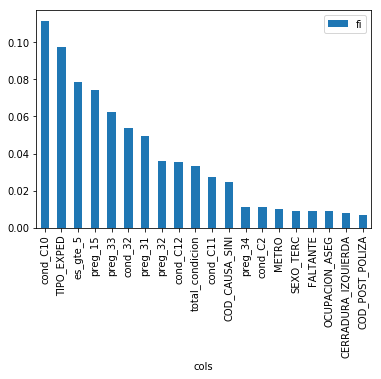

In [54]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [55]:
to_keep = list(rf_fi[rf_fi["fi"] >=0.005]["cols"].values)
print(f"# of features: {len(to_keep)} of {len(rf_fi)}")

# of features: 26 of 143


In [56]:
to_remove = ['COD_POST_POLIZA_RT_CLUSTER_2019', 'COD_POST_OCURRENCIA_RT_CLUSTER_2019',
             'COD_POST_OCURRENCIA_RC_CLUSTER_2019',  'COD_POST_POLIZA_RC_CLUSTER_2019',
             'COD_POST_OCURRENCIA_DP_CLUSTER_2019', 'COD_POST_POLIZA_DP_CLUSTER_2019',
             "es_gte_5", 
            ] # "total_condicion", "es_gte_5", 
for col in to_remove:
    if(col in to_keep):
        to_keep.remove(col)
to_keep

['cond_C10',
 'TIPO_EXPED',
 'preg_15',
 'preg_33',
 'cond_32',
 'preg_31',
 'preg_32',
 'cond_C12',
 'total_condicion',
 'cond_C11',
 'COD_CAUSA_SINI',
 'preg_34',
 'cond_C2',
 'METRO',
 'SEXO_TERC',
 'FALTANTE',
 'OCUPACION_ASEG',
 'CERRADURA_IZQUIERDA',
 'COD_POST_POLIZA',
 'SEXO',
 'FECHA_SINI_Dayofweek',
 'preg_16',
 'DESCRIPCION_TIPO',
 'CONV_COMISIONARIO',
 'cond_C3']

In [57]:
# best model
clf.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=33,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [58]:
X_train_red = X_train[to_keep].copy()

In [59]:
print(len(X_train_red.columns))

25


### Training again with less features

In [60]:
# rf = RandomForestClassifier(n_estimators=40, max_features=0.5, min_samples_leaf=7, random_state=random_state, n_jobs=-1)
rf = copy(clf.best_estimator_)
rf.fit(X_train_red, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=33,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [69]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.33279483037156704, 0.8272093253023898)

In [70]:
confusion_matrix(y_val, y_val_pred)

array([[70781,   722],
       [  104,   206]])

In [61]:
y_val_pred = rf.predict(X_val[to_keep])
y_val_f1_bestFI, y_val_rocauc_bestFI = f1_score(y_val, y_val_pred), roc_auc_score(y_val, y_val_pred)
y_val_f1_bestFI, y_val_rocauc_bestFI

(0.2346193952033368, 0.8532323029081117)

In [62]:
confusion_matrix(y_val, y_val_pred)

array([[70120,  1383],
       [   85,   225]])

In [63]:
rf_fi = pd.DataFrame({'cols':X_train_red.columns, 'fi':rf.feature_importances_}).sort_values('fi', ascending=False)
rf_fi[:10]

,cols,fi
2,preg_15,0.173357
6,preg_32,0.108657
8,total_condicion,0.101005
1,TIPO_EXPED,0.094145
3,preg_33,0.090596
0,cond_C10,0.090101
7,cond_C12,0.049416
9,cond_C11,0.041909
5,preg_31,0.030913
10,COD_CAUSA_SINI,0.026505


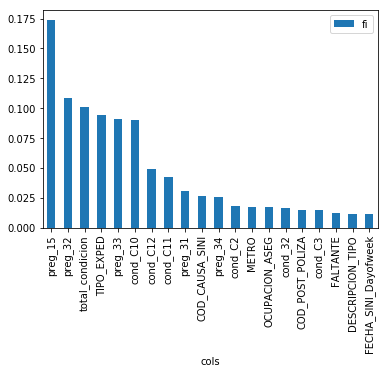

In [64]:
rf_fi[:20].plot.bar(x="cols")
plt.xticks(rotation="vertical")
plt.show()

In [ ]:
# best columns used
rf_fi["cols"].values

# final model

In [ ]:
# reset_rf_samples()

## full features final model

In [41]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train, y_full_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1, 1: 9},
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=55,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=40, n_jobs=-1, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [42]:
y_val_pred = rf_full.predict(X_val)
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, rf_full.predict_proba(X_val)[:, -1])
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.449, 0.973


In [43]:
confusion_matrix(y_val, y_val_pred)

array([[71143,   360],
       [  116,   194]])

## red features final model (dummies)

In [40]:
X_full_train_dummy = pd.get_dummies(X_full_train[to_keep], columns=to_keep)
X_full_train_dummy.head()

,cond_C10_-1.0,cond_C10_0.0,cond_C10_5.0,preg_15_-1,preg_15_0,preg_15_1,preg_15_2,preg_15_3,preg_15_4,preg_15_5,TIPO_EXPED_0,TIPO_EXPED_1,TIPO_EXPED_2,TIPO_EXPED_3,TIPO_EXPED_4,TIPO_EXPED_5,TIPO_EXPED_6,preg_33_-1,preg_33_0,preg_33_1,preg_31_-1,preg_31_0,preg_31_1,cond_32_-1.0,cond_32_0.0,cond_32_2.0,preg_32_-1,preg_32_0,preg_32_1,total_condicion_0.0,total_condicion_1.0,total_condicion_2.0,total_condicion_3.0,total_condicion_4.0,total_condicion_5.0,total_condicion_6.0,total_condicion_7.0,total_condicion_8.0,total_condicion_9.0,total_condicion_10.0,total_condicion_11.0,total_condicion_12.0,total_condicion_13.0,total_condicion_15.0,cond_C11_-1.0,cond_C11_0.0,cond_C11_3.0,cond_C11_4.0,cond_C11_5.0,cond_C12_-1.0,cond_C12_0.0,cond_C12_3.0,COD_CAUSA_SINI_4.0,COD_CAUSA_SINI_10.0,COD_CAUSA_SINI_12.0,COD_CAUSA_SINI_14.0,COD_CAUSA_SINI_15.0,COD_CAUSA_SINI_24.0,COD_CAUSA_SINI_55.0,COD_CAUSA_SINI_62.0,COD_CAUSA_SINI_71.0,COD_CAUSA_SINI_75.0,COD_CAUSA_SINI_119.0,COD_CAUSA_SINI_122.0,COD_CAUSA_SINI_200.0,COD_CAUSA_SINI_201.0,COD_CAUSA_SINI_202.0,COD_CAUSA_SINI_203.0,COD_CAUSA_SINI_204.0,COD_CAUSA_SINI_205.0,COD_CAUSA_SINI_206.0,COD_CAUSA_SINI_207.0,COD_CAUSA_SINI_208.0,COD_CAUSA_SINI_209.0,COD_CAUSA_SINI_226.0,COD_CAUSA_SINI_501.0,COD_CAUSA_SINI_502.0,COD_CAUSA_SINI_503.0,COD_CAUSA_SINI_504.0,COD_CAUSA_SINI_505.0,COD_CAUSA_SINI_506.0,COD_CAUSA_SINI_507.0,COD_CAUSA_SINI_508.0,cond_C2_-1.0,cond_C2_3.0,SEXO_TERC_-1,SEXO_TERC_0,SEXO_TERC_1,METRO_-1,METRO_0,METRO_1,FALTANTE_0,FALTANTE_1,OCUPACION_ASEG_-1.0,OCUPACION_ASEG_0.0,OCUPACION_ASEG_1.0,OCUPACION_ASEG_2.0,OCUPACION_ASEG_3.0,OCUPACION_ASEG_4.0,OCUPACION_ASEG_5.0,OCUPACION_ASEG_6.0,OCUPACION_ASEG_7.0,OCUPACION_ASEG_8.0,OCUPACION_ASEG_9.0,OCUPACION_ASEG_10.0,OCUPACION_ASEG_11.0,OCUPACION_ASEG_13.0,OCUPACION_ASEG_14.0,OCUPACION_ASEG_15.0,OCUPACION_ASEG_16.0,OCUPACION_ASEG_17.0,OCUPACION_ASEG_18.0,OCUPACION_ASEG_19.0,OCUPACION_ASEG_20.0,OCUPACION_ASEG_21.0,OCUPACION_ASEG_22.0,OCUPACION_ASEG_23.0,OCUPACION_ASEG_24.0,OCUPACION_ASEG_25.0,OCUPACION_ASEG_26.0,OCUPACION_ASEG_27.0,OCUPACION_ASEG_28.0,OCUPACION_ASEG_29.0,OCUPACION_ASEG_30.0,OCUPACION_ASEG_31.0,OCUPACION_ASEG_32.0,OCUPACION_ASEG_33.0,OCUPACION_ASEG_34.0,OCUPACION_ASEG_35.0,OCUPACION_ASEG_36.0,OCUPACION_ASEG_37.0,OCUPACION_ASEG_38.0,OCUPACION_ASEG_39.0,OCUPACION_ASEG_40.0,OCUPACION_ASEG_41.0,OCUPACION_ASEG_42.0,OCUPACION_ASEG_43.0,OCUPACION_ASEG_44.0,OCUPACION_ASEG_45.0,OCUPACION_ASEG_46.0,OCUPACION_ASEG_999.0,OCUPACION_ASEG_9999.0,OCUPACION_ASEG_99999.0,preg_16_-1,preg_16_0,preg_16_1,preg_16_2,preg_16_3,preg_16_4,cond_C5_-1.0,cond_C5_0.0,cond_C5_2.0
0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0

In [41]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train_dummy, y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 23},
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=55,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [44]:
y_val_pred_prob = rf_full.predict_proba(pd.get_dummies(X_val[to_keep], columns=to_keep))[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

ValueError: Number of features of the model must match the input. Model n_features is 152 and input n_features is 142 

In [ ]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

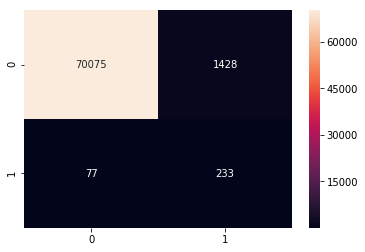

In [43]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## red features final model

In [65]:
rf_full = copy(clf.best_estimator_)
rf_full.fit(X_full_train[to_keep], y_full_train)

ExtraTreesClassifier(bootstrap=False, class_weight={0: 1, 1: 20},
           criterion='gini', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=33,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [66]:
y_val_pred_prob = rf_full.predict_proba(X_val[to_keep])[:, -1]
y_val_pred = y_val_pred_prob > 0.5
y_val_f1_bestFI = f1_score(y_val, y_val_pred)
y_val_rocauc_bestFI = roc_auc_score(y_val, y_val_pred_prob)
print("%.3f, %.3f" % (y_val_f1_bestFI, y_val_rocauc_bestFI))

0.299, 0.973


In [67]:
confusion_matrix(y_val, y_val_pred)

array([[70549,   954],
       [   88,   222]])

In [37]:
conf_mat = confusion_matrix(y_val, y_val_pred)
conf_mat

array([[70075,  1428],
       [   77,   233]])

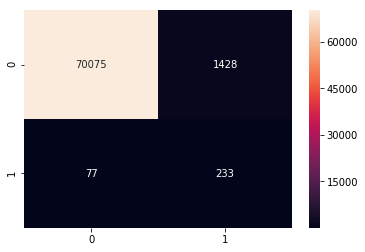

In [38]:
sns.heatmap(conf_mat, annot=True, fmt="d")

## Tronador (sum cond >=5) comparison

In [71]:
# comparing against > 5 logic
y_tronador = X_val["total_condicion"] >= 5
print(f"({f1_score(y_val, y_tronador)},{roc_auc_score(y_val, y_tronador)})")

(0.3472949389179756,0.8165133833771018)


In [72]:
conf_mat = confusion_matrix(y_val, y_tronador)
conf_mat

array([[70866,   637],
       [  111,   199]])

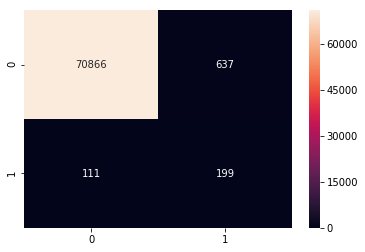

In [73]:
sns.heatmap(conf_mat, annot=True, fmt="d")

# Saving final model & columns used into hard drive

In [77]:
path_to_save = "../../src/models/1.1 - df_train 01-18to12-18/"
model_file = os.path.join(path_to_save, "1.1.b.2.f (Model) - Model Optimization recall - class_weight balanced - time sorted - valid score (0.452, 0.978).pickle")

with open(model_file, "wb") as f:
    pickle.dump(rf_full, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# save file for humans
# model_file = "../../models/1.0 - df_train with nan 01-17to12-18/1.0 - Model for humans - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle"

# with open(model_file, "wb") as f:
#    pickle.dump(rf_full, f, 0) # 0 is human readable format

In [78]:
# merging list input & target
full_cols = list(to_keep) + ["EXISTE_FRAUDE"]
print(full_cols)

['cond_C10', 'es_gte_5', 'TIPO_EXPED', 'preg_15', 'cond_C12', 'preg_32', 'cond_32', 'preg_33', 'preg_31', 'cond_C11', 'preg_34', 'COD_CAUSA_SINI', 'cond_C2', 'cond_C3', 'METRO', 'SEXO_TERC', 'OCUPACION_ASEG', 'FALTANTE', 'cond_C5', 'CONDICION_ROBO_EXP50', 'EXISTE_FRAUDE']


In [79]:
path_to_save = "../../src/features/1.1 - df_train 01-18to12-18/"
columns_file = os.path.join(path_to_save, "1.1.b.2.f (COLUMNS) - Model Optimization - class_weight balanced - time sorted - valid score (0.696, 0.999).pickle")

with open(columns_file, "wb") as file:
    pickle.dump(full_cols, file, pickle.HIGHEST_PROTOCOL)

In [81]:
# saving for example a few rows to implement the model
path_to_save = "../../src/data/1.1 - df_train 01-18to12-18/"
sample_file = os.path.join(path_to_save, "1.1.b.2.f (sample)  - dataset example to predict model.csv")

df_example = X_val.loc[:, to_keep][-50:]
df_example["EXISTE_FRAUDE"] = y_val[-50:]
df_example.to_csv(sample_file)

In [ ]:
df_example.head()